#### Last Updated: 01/25/21

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Initializion of a Lattice

To initialize a simulation, we start by generating a lattice of atoms. Solid argon is stable in a face-centered cubic lattice [(Barrett and Meyer, 1965)](https://link.springer.com/chapter/10.1007%2F978-1-4899-6443-4_93), so we initialize with 4 atoms in each unit cell. 

In [3]:
kb = 1.3806e-23
e = 1.6022e-19
L = 10 #Lattice size
b = 1 #Size of unit cell
N = 4 * (L**3) #Number of atoms
print(N)
X = np.zeros((N,3)) #Initialize the positions

4000


Now we need to update our position array **X**. If $b$ is the dimension of a unit cell, then for the unit cell starting at $r_0 = (r_x, r_y, r_z)$ the atoms are at $(r_x, r_y, r_z), (r_x + b/2, r_y + b/2, r_z), (r_x + b/2, r_y, r_z + b/2),$ and $(r_x, r_y + b/2, r_z + b/2)$. Thus given the unit cell position $r_0$, we can get the positions of the atoms via $r_0 + (0,0,0), r_0 + (b/2, b/2, 0), r_0 + (b/2, 0, b/2), $ and $r_0 + (0, b/2, b/2)$. This motivates the construction of **b_list** below.

In [4]:
#Update position array
b_list = [(0,0,0),(b/2, b/2, 0),(b/2, 0, b/2),(0,b/2,b/2)]
p = 0 #Count the particles for indexing
for x in range(L):
    for y in range(L):
        for z in range(L):
            x_0 = np.array((x, y, z)) * b #position of unit cell
            for i in range(4):
                X[p] = x_0 + b_list[i]
                p += 1
assert p == N

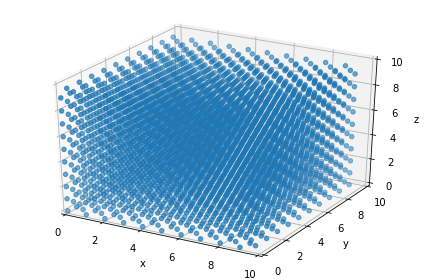

In [5]:
#Plot the lattice
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.set_xlim(0,L*b)
ax.set_ylim(0,L*b)
ax.set_zlim(0,L*b)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter(X[:,0], X[:,1], X[:,2])
plt.tight_layout()
plt.show()

Now we need to assign initial velocities to each atom. The value of **T_0** will determine whether the atoms begin at rest or with a random (normal) distribution of velocities.

In [32]:
T_0 = 300
mass = 39.95 #Argon
V = np.random.randn(N,3) * np.sqrt(kb * T_0 / (mass * e))

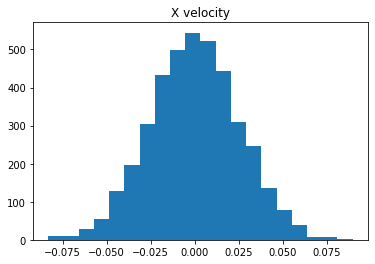

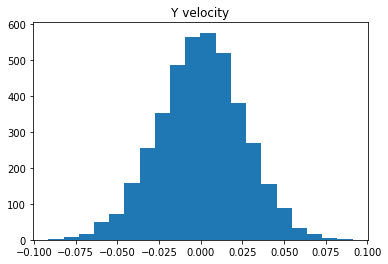

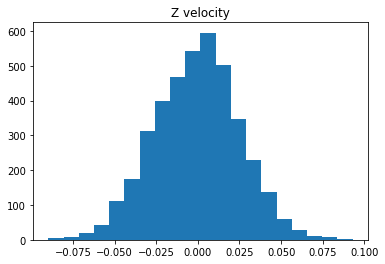

In [33]:
hist_titles = ['X velocity', 'Y velocity', 'Z velocity']
for i in range(3):
    plt.figure()
    plt.hist(V[:,i], bins=20)
    plt.title(hist_titles[i])
    plt.show()

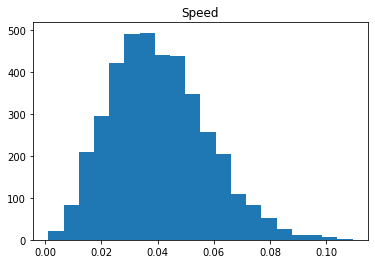

In [34]:
speeds = []
for i in V:
    speed = np.sqrt(i[0]**2 + i[1]**2 + i[2]**2)
    speeds.append(speed)
plt.hist(speeds, bins=20)
plt.title('Speed')
plt.show()

## Force Field Construction from Lennard-Jones Potential

Argon is inert, apolar, and monotomic as a fluid, enabling simplifications in modelling. The relevant force field parameters are Pauli repulsion and London dispersion, which can be described with a Lennard-Jones potential: $$ U_{LJ}(r) = 4 \epsilon \Big( \big(\frac{\sigma}{r}\big)^{12} - \big(\frac{\sigma}{r}\big)^{6} \Big) $$
where $r$ is the distance between atoms, $\sigma$ is the distance at which $U = 0$, and $\epsilon$ is the minimum potential (i.e. the well depth). $\sigma$ and $\epsilon$ are characteristic of the substance. For argon, we use the Rowley, Nicholson and Parsonage parameters $\epsilon = 119.8$K $= 0.01032$eV ([NIST converstion](https://physics.nist.gov/cgi-bin/cuu/Convert?exp=6&num=160&From=ev&To=k&Action=Convert+value+and+show+factor)) and $\sigma = 3.405 $A (see the [argon page on SklogWiki](http://www.sklogwiki.org/SklogWiki/index.php/Argon#Lennard-Jones_parameters)). We use 39.95 amu for the mass of an argon atom.

In [9]:
#Argon constants
epsilon = 119.8 #K
sigma = 3.405

In [10]:
def potential(r):
    U = 4 * epsilon * ((sigma/r)**12 - (sigma/r)**6)
    return U

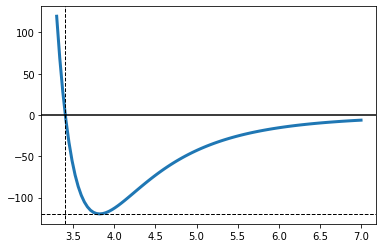

In [11]:
#Plot U(r)
u_test = np.linspace(3.3,7, 100)
plt.plot(u_test, potential(u_test), linewidth=3)
plt.axhline(0, color='black', linewidth=1.5)
plt.axvline(sigma, color='black',linestyle='--', linewidth=1)
plt.axhline(-epsilon, color='black', linestyle='--', linewidth=1)
plt.show()

Taking the derivative of $U_{LJ}$ gives us an expression for force: 
$$F(r) = -\frac{dU}{dr} = \frac{24 \epsilon}{r}\Big(2\big(\frac{\sigma}{r}\big)^{12} - \big(\frac{\sigma}{r}\big)^{6}\Big) $$

In [12]:
def force(r):
    F = 24 * (epsilon/r) * (2*(sigma/r)**12 - (sigma/r)**6)
    return F

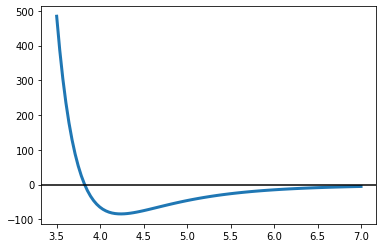

In [13]:
#Plot F(r)
f_test = np.linspace(3.5,7, 100)
plt.plot(f_test, force(f_test), linewidth=3)
plt.axhline(0, color='black', linewidth=1.5)
plt.show()

We can then use Newton's second law to compute the accelertion induced by a pair of atoms.

In [14]:
def acceleration(positions): #N x 1 array
    positions = np.array(positions)
    accelerations = np.zeros((positions.size, positions.size))
    for i in range(positions.size - 1):
        for j in range(i+1, positions.size): #use Newton's third law instead of re-computing both directions
            r = positions[j] - positions[i]
            if r == 0: #preemptive check to avoid dividing by 0 with 3D particles
                continue
            r_mag = np.sqrt(r ** 2)
            force_mag = force(r_mag)
            force_vec = force_mag * (r / r_mag)
            accelerations[i,j] = force_vec / mass
            accelerations[j,i] = - accelerations[i,j] #Newton's third law
    return np.sum(accelerations, axis=0) #N x 1 array

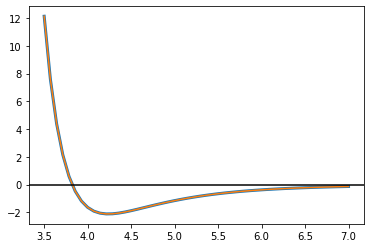

In [15]:
#Plot 1D acceleration and force/mass
a_test = np.linspace(3.5, 7)
accelerations = []
for r in a_test:
    a = acceleration([0, r])[1]
    accelerations = np.append(accelerations, a)
plt.plot(a_test, accelerations, linewidth=3)
plt.plot(a_test, force(a_test)/mass)
plt.axhline(0, color='black', linewidth=1.5)
plt.show()

The plot of acceleration is just the plot of force rescaled by the mass, which means the function is working properly.

In [16]:
#Generalize to 3 dimensions
def acceleration3D(positions): #N x 3 array
    positions_x = positions[:,0]
    positions_y = positions[:,1]
    positions_z = positions[:,2]
    acceleration_x = acceleration(positions_x)
    acceleration_y = acceleration(positions_y)
    acceleration_z = acceleration(positions_z)
    return np.transpose(np.array([acceleration_x, acceleration_y, acceleration_z])) #N x 3 array

## Integration of Newton's Equations

We'll use the [velocity Verlet algorithm](https://en.wikipedia.org/wiki/Verlet_integration#Velocity_Verlet) to integrate Newton's Equations: $$ x(t+ \Delta t) = x(t) + v(t) \Delta t + \frac{1}{2} a(t) \Delta t^{2}$$ $$ v(t + \Delta t) = v(t) + \frac{1}{2}\big( a(t) + a(t + \Delta t) \big) \Delta t $$

In [17]:
def initializevelocity(T, N):
    V = np.random.randn(N)
    V = V * np.sqrt((kb * T) / (mass * e))
    return V

In [18]:
def positionupdate(x, v, a, dt):
    new_position = x + (v * dt) + (0.5 * a * (dt**2))
    return new_position

In [19]:
def velocityupdate(v, a_0, a_1, dt):
    new_velocity = v + (0.5 * (a_0 + a_1) * dt)
    return new_velocity

In [20]:
epsilon = 0.0103 #eV

In [21]:
def simulate(iterations, X, T_0, dt):
    N = len(X)
    all_positions = np.zeros((iterations, N))
    all_velocities = np.zeros((iterations, N))
    V = initializevelocity(T_0, N)
    a = acceleration(X)
    for i in range(iterations):
        X = positionupdate(X, V, a, dt)
        a1 = acceleration(X)
        V = velocityupdate(V, a, a1, dt)
        a = a1
        all_positions[i] = X
        all_velocities[i] = V
    return all_positions, all_velocities

## Simulations in 1D

Let's plot the results of some 1D simulations while varying the starting temperature and number of particles.

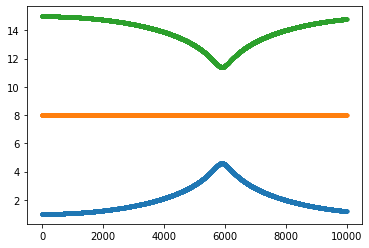

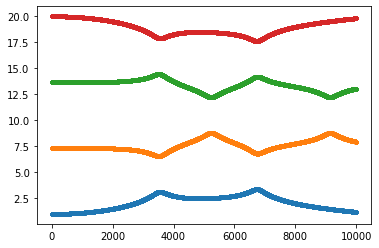

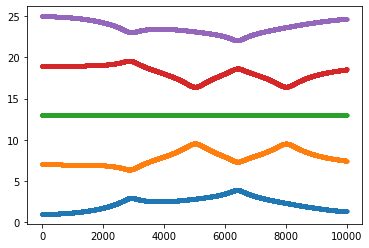

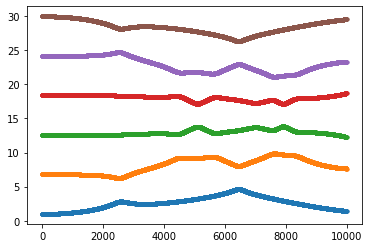

In [22]:
#T=0
for i in range(3, 7):
    x = np.linspace(1, 5 * i, i)
    sim = simulate(10000, x, 0, 0.1)[0]
    plt.figure()
    for j in range(i):
        plt.plot(sim[:,j], '.')

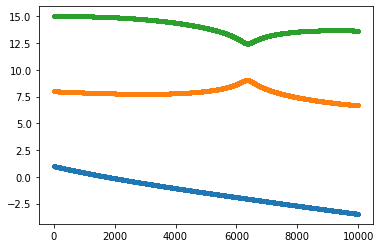

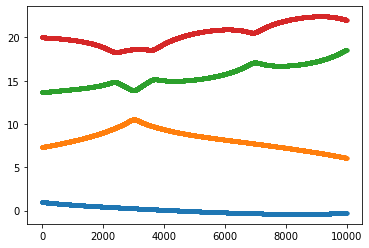

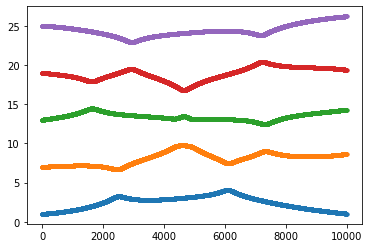

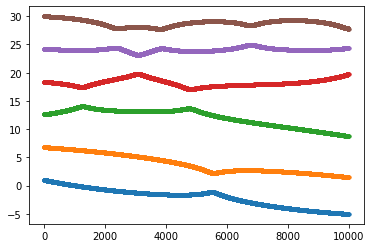

In [23]:
#T=10
for i in range(3, 7):
    x = np.linspace(1, 5 * i, i)
    sim = simulate(10000, x, 10, 0.1)[0]
    plt.figure()
    for j in range(i):
        plt.plot(sim[:,j], '.')

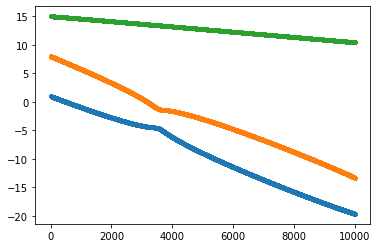

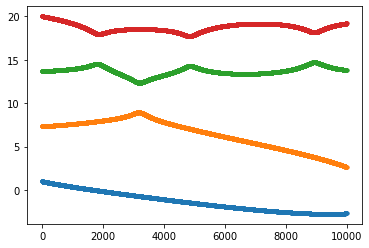

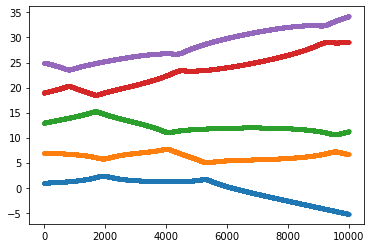

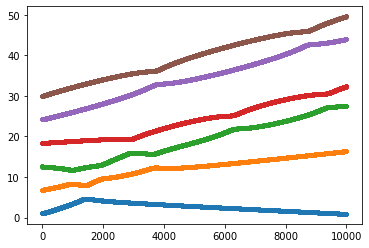

In [24]:
#T=100
for i in range(3, 7):
    x = np.linspace(1, 5 * i, i)
    sim = simulate(10000, x, 100, 0.1)[0]
    plt.figure()
    for j in range(i):
        plt.plot(sim[:,j], '.')

## Energy Calculations

In [25]:
def potentialenergy(simulation):
    positions = simulation[0]
    pe_list = [] 
    for row in positions: 
        row_pe = 0 
        for i in range(len(row) - 1): 
            for j in range(i, len(row)): 
                r = row[j] - row[i]  
                if r == 0:
                    continue
                row_pe += potential(r) 
        pe_list.append(row_pe) 
    return pe_list 

In [26]:
def kineticenergy(simulation): 
    velocities = simulation[1] 
    ke_list = [] 
    for row in velocities: 
        row_ke = 0 
        for velocity in row: 
            row_ke += (0.5 * mass * (velocity**2)) 
        ke_list.append(row_ke) 
    return ke_list 

In [27]:
def mechanicalenergy(simulation):
    ke = np.array(kineticenergy(simulation))
    pe = np.array(potentialenergy(simulation))
    return ke + pe

We'll plot the kinetic, potential, and total (mechanical) energies for each of the simulations above.

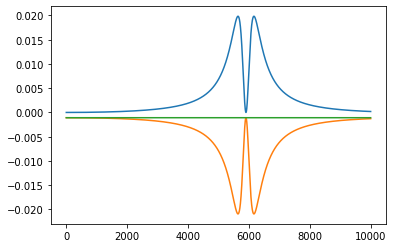

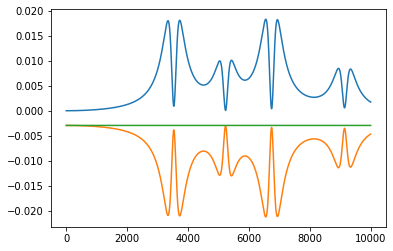

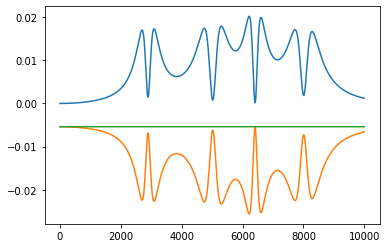

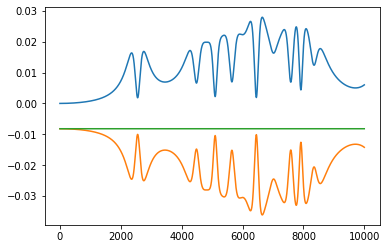

In [28]:
#T=0
for i in range(3, 7):
    x = np.linspace(1, 5 * i, i)
    sim = simulate(10000, x, 0, 0.1)
    ke = kineticenergy(sim)
    pe = potentialenergy(sim)
    me = mechanicalenergy(sim)
    plt.figure()
    plt.plot(ke)
    plt.plot(pe)
    plt.plot(me)
    plt.show()

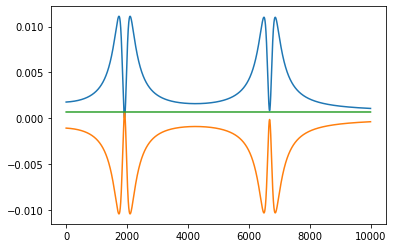

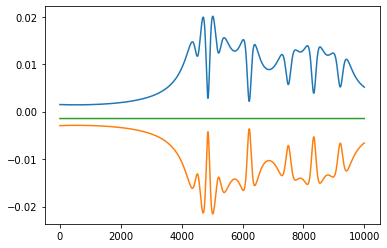

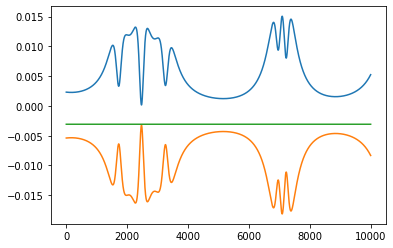

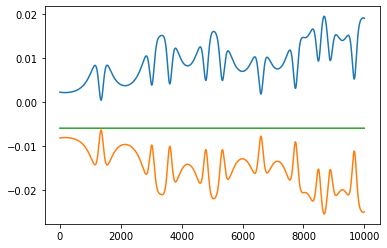

In [29]:
#T=10
for i in range(3, 7):
    x = np.linspace(1, 5 * i, i)
    sim = simulate(10000, x, 10, 0.1)
    ke = kineticenergy(sim)
    pe = potentialenergy(sim)
    me = mechanicalenergy(sim)
    plt.figure()
    plt.plot(ke)
    plt.plot(pe)
    plt.plot(me)
    plt.show()

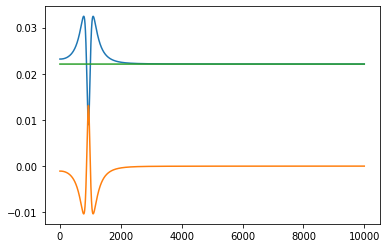

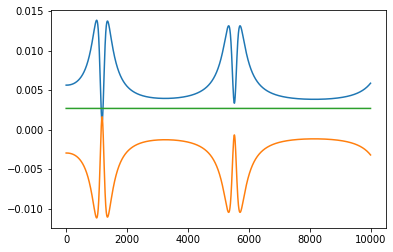

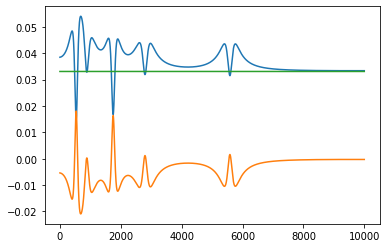

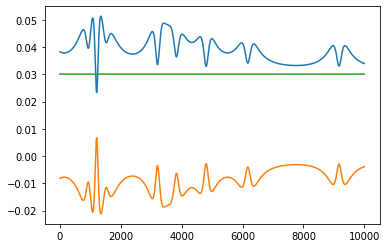

In [30]:
#T=100
for i in range(3, 7):
    x = np.linspace(1, 5 * i, i)
    sim = simulate(10000, x, 100, 0.1)
    ke = kineticenergy(sim)
    pe = potentialenergy(sim)
    me = mechanicalenergy(sim)
    plt.figure()
    plt.plot(ke)
    plt.plot(pe)
    plt.plot(me)
    plt.show()

Mechanical energy is near-constant, which suggests that our simulation is working.

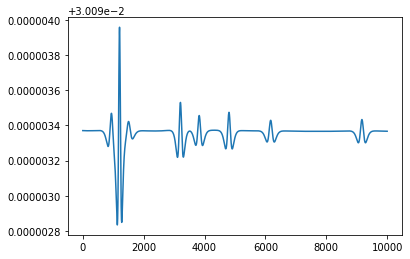

In [35]:
#Fluctuations in ME are very small
plt.plot(me)
plt.show()